In [1]:
from mammoth import *

2023-05-17 16:26:32.474107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## I will build time series data by myself

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

seq_len = 1000
x = np.arange(seq_len)

series_1 = (np.log2(np.arange(seq_len)+1)+2*np.arange(seq_len)**0.5+
            4*np.sin(0.2*(x+1))+5*np.cos(x+12)+7*np.cos(0.04*(x-8))+
            np.random.random(seq_len)*5.5)
series_1 = pd.DataFrame({'series_key':['series_1']*seq_len, 
                         'time_idx':x,
                         'y':series_1,
                         'sin_wx':np.sin(0.2*(x+1)),
                         'cos_wx':np.cos(x+12)})

series_2 = (0.0002*(np.arange(seq_len)-400)**2+40+
            7*np.sin(0.5*(x+1))+10*np.cos(0.1*x)-4*np.cos(0.9*(x-20))+20*np.sin(0.02*(x+4))+
            np.random.random(seq_len)*5)
series_2 = pd.DataFrame({'series_key':['series_2']*seq_len, 
                         'time_idx':x,
                         'y':series_2,
                         'sin_wx':np.sin(0.02*(x+4)),
                         'cos_wx':np.cos(0.9*(x-20))})

series_3 = (np.log2(200-10*np.arange(seq_len)**0.2)**3/10+
            3*np.sin(0.05*(x-9))+2*np.sin(0.01*x)-np.cos(8*(x-10))-3*np.sin(0.2*(x+40))+
            np.random.random(seq_len)*4)
series_3 = pd.DataFrame({'series_key':['series_3']*seq_len, 
                         'time_idx':x,
                         'y':series_3,
                         'sin_wx':np.sin(0.01*x),
                         'cos_wx':np.cos(8*(x-10))})

data = pd.concat([series_1, series_2, series_3], ignore_index=True)
data['key_embed'] = data['series_key'].copy()

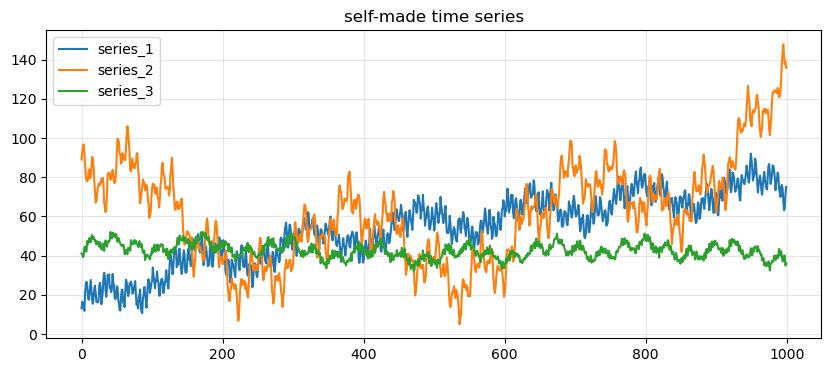

In [3]:
plt.figure(figsize=(10,4), dpi=100)
for key in data['series_key'].unique():
    plt.plot(data[data['series_key']==key]['y'].values, label=key)
plt.legend()
plt.grid(alpha=0.3)
plt.title('self-made time series')
plt.show()

# Build dataset for training and forecasting
***

<font size=4>**dsbuilder** is the function to generate dataset for train, validation and forecast.</font>

***
<font size=3>***input_settings*** is a dictionary contains the basic settings for preprocessing.</font>

Required keys for 'input_settings' are as follows:

* `seq_key` $<List/string/integer>$ The primary key of time series.
* `seq_label` $<List/string/integer>$ The columns to identity the time sequence, such as calendar date or cumulative number.
* `seq_target` $<List/string/integer>$ The target to predict.
* `perc_horizon` $<integer>$ The size of looking back window, which means how long of historical data you will refer to.
* `fcst_horizon` $<integer>$ The prediction length.
        
Alternative keys for 'input_settings' are as follows:
* `enc_feat` $<List>$ The name of features used in the encoding part. default: [].
* `dec_feat` $<List>$ The name of features used in the decoding part. default: [].
* `embed_feat` $<List>$ The name of embedding features. default: [].
* `norm_feat` $<dictionary>$ The features you want to normalize. It is recommended to define 'norm_feat' within 'single_tsm' function. When you define 'norm_feat' here, there won't be trainable weights on mean and standard deviation. default: {}.
* `min_avail_perc_rate` $<float>$ The minimum rate of padding time points verus perception horizon. When exceeded, the data at that time point will be padded. default: 0.25.
* `min_avail_seq_rate` $<float>$ The minimum rate of padding time points verus each time series. Exceeded time series won't be trained. default: 0.5.
* `window_freq` $<integer>$ The strides of sliding window to get time series pieces. default: 1.
* `val_rate` $<float>$ The rate of validation part in train data. If None, no validation data will be built. default: None

***
<font size=3>***train_settings*** is a dictionary contains the basic settings for training.</font>

Alternative settings are as follows:

* `optimizer` The optimizer function. It can either be a function in 'tensorflow.keras.optimizers' or the string representing the function. For detail, please refer to tensorflow.keras tutorial. default: 'adam'.
* `learning_rate` default: 0.01.
* `loss_func` It can be a python func(refer to tensorflow.keras tutorial for how to build self-defined Loss Function or string. Also it can be any iterable object(e.g. 'list' or 'tuple') containing different losses(e.g. ['mae','mse']). default: 'mae'.
* `loss_weights` Same parameter in 'tensorflow.keras.model.Model.compile'. default: None.
* `weighted_metrics` Same parameter in 'tensorflow.keras.model.Model.compile'. default: ['mae', PearsonCoef].
* `batch_size` Same parameter in 'tensorflow.keras.model.Model.fit'. default: 16.
* `epochs` Same parameter in 'tensorflow.keras.model.Model.fit'. default: 1000.
* `callbacks` Same parameter in 'tensorflow.keras.model.Model.fit'. For detail in defining your own callback functino, please refer to 'tensorflow.keras.callbacks'. default: [EarlyStopping(monitor='loss', patience=10)].
* `verbose` Same parameter in 'tensorflow.keras.model.Model.fit'. default: 1.
* `validation_steps` Same parameter in 'tensorflow.keras.model.Model.fit'. default: None.
* `validation_batch_size` Same parameter in 'tensorflow.keras.model.Model.fit'. default: None.
* `validation_freq` Same parameter in 'tensorflow.keras.model.Model.fit'. default: 1.
* `use_multiprocessing` Same parameter in 'tensorflow.keras.model.Model.fit'. Note that: 'multiprocessing' is not available when used GPU numbers < 2 or tensorflow version < 2.5.0. default: True. 
* `shuffle` Same parameter in 'tensorflow.keras.model.Model.fit'. default: True.

***
Callable Arguments:
* `train_data` $<pandas.DataFrame>$ The dataframe used for training.
* `fcst_data` $<pandas.DataFrame>$ The dataframe used for forecasting.
* `embed_data` $<pandas.DataFrame>$ The dataframe used for embedding.

***
Return:
* `train_dataset` $<tensorflow.data.Dataset>$ Dataset for training.
* `val_dataset` $<tensorflow.data.Dataset>$ Dataset for validation.
* `fcst_dataset` $<tensorflow.data.Dataset>$ Dataset for forecasting.
* `input_settings` $<dictionary>$ Updated input_settings.
* `prediction` $<pandas.DataFrame>$ The primary key frame of forecast, including seq_key and seq_label.

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
from mammoth.losses import PearsonCoef
tf_ignore_warnings() ## Ignore warnings

## define input_settings
input_settings = {'seq_key':['series_key'],
                  'seq_label':['time_idx'],
                  'seq_target':['y'],
                  'perc_horizon':128,'fcst_horizon':100,
                  'enc_feat':['sin_wx', 'cos_wx'], 
                  'dec_feat':['sin_wx', 'cos_wx'], 
                  'embed_feat':['key_embed'], 'window_freq':1, 
                  'verbose':'auto',
                  'val_rate':0.2}

## define train_settings
train_settings = {'learning_rate':0.01, 'loss_func':'mae', 'batch_size':3,
                  'weighted_metrics':['mae',PearsonCoef],
                  'epochs':200, 'callbacks':[EarlyStopping(monitor='val_loss', patience=10)],
                  'use_multiprocessing':False}

train_data = data[data['time_idx']<=900]
fcst_data = data[data['time_idx']>900]
embed_data = data[input_settings['seq_key']+input_settings['embed_feat']].drop_duplicates()

## Use 'dsbuilder' to create datasets for training, validation and forecasting
train_dataset,\
val_dataset,\
fcst_dataset, \
input_settings, \
prediction = dsbuilder(input_settings)(train_data, fcst_data, embed_data)

/Users/diggerwang/Desktop/github/mammoth/mammoth/data_loader.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['_count_'] = 1
/Users/diggerwang/Desktop/github/mammoth/mammoth/data_loader.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['_count_'] = 1


## Build time series models
***

<font size=4>**signle_tsm** is the function to generate single time series model.</font>

***
<font size=3>**Arguments**</font>

***input_settings*** \
See the tutourials above.

***train_settings*** \
See the tutourials above.

***embedding*** \
A dictionary whose key is the method of embedding, normally string type, and value is also a dictionary which contains the hyperparameter for embedding(e.g. {'SimpleEmbedding':{'n_embed_layers':2}}).
The builtin embedding is called 'SimpleEmbedding'. For customized embedding function, please refer to `mammoth.model.nn_blocks.ModelBlock`. default: {'SimpleEmbedding':{}}.
        
***encoder*** \
A dictionary whose key is the method of time series encoding, normally string type, and value is also a dictionary which contains the hyperparameter for encoding(e.g. {'WavenetEncoder':{'n_enc_filters':8, 'n_enc_layers':6}}).
There are 4 builtin encoding methods:
* `WavenetEncoder` -> https://arxiv.org/pdf/1609.03499v2.pdf
* `TransformerEncoder` -> https://arxiv.org/pdf/1706.03762v5.pdf
* `InformerEncoder` -> https://arxiv.org/pdf/2012.07436v3.pdf
* `SciEncoder` -> https://arxiv.org/pdf/2106.09305v3.pdf

For customized encoding function, please refer to `mammoth.model.nn_blocks.ModelBlock`. default: {'WavenetEncoder':{}}.
        
***decoder*** \
A dictionary whose key is the method of time series decoding, normally string type, and value is also a dictionary which contains the hyperparameter for decoding(e.g. {'DenseDecoder':{'dec_activation':'elu'}}).
There are 2 builtin decoding methods:
* `DenseDecoder` -> The most common decoding methods. Using fully connected layers after the encoder part to get decoder part.
* `CaCtDecoder` -> https://arxiv.org/pdf/1711.11053v2.pdf

For customized decoding function, please refer to mammoth.model.nn_blocks.ModelBlock. default: {'DenseDecoder':{}}.

***recoder*** \
A dictionary whose key is the method of time series reverse encoding, normally string type, and value is also a dictionary which contains the hyperparameter for reverse encoding(e.g. {'ConvRecoder':{'n_rec_layers':2}}). Reverse encoding is used in multi-horizon forecasting. When you have enough future information and use them as the latent features, you can reverse encode the future information to its relative past time points.
There are 1 builtin reverse encoding method:
* `ConvRecoder` -> Use convolution to encode future information to now reversely.

For customized reverse encoding function, please refer to mammoth.model.nn_blocks.ModelBlock. default: {'ConvRecoder':{}}.
        
***output*** \
A dictionary whose key is the method of output, normally string type, and value is also a dictionary which contains the hyperparameter for output(e.g. {'MlpOutput':{'mlp_dims':[16,8]}}).
There are 3 builtin output methods:
* `MlpOutput` -> The most common output methods. Just use several fully connected layers to get the final output.
* `AttentionOutput` -> The attention mechanism applied on the feature dimension. Usually used in attention-related models, e.g. Informer.
* `TabnetOutput` -> Using TabNet for the final regression or classification. For TabNet, please refer to https://arxiv.org/pdf/1908.07442v5.pdf.

***is_fork*** \
Whether use fork training. Fork training is only available to RNN-based and RNN-based models, e.g. 'WaveNet' and 'SCINet'. Fork training can save memory and speed up training process.
        
***norm_feat*** \
A dictionary whose key is the normalization methods, and value is a iterable object that contains features you want to normalize. e.g. {'standard':['f1', 'f2']}. There are 4 normalization methods:
* `standard`: $\frac{x-avg(x)}{std(x)}$
* `minmax`: $\frac{x-min(x)}{max(x)-min(x)}$
* `mean`: $\frac{x}{avg(x)}$
* `maxabs`: $\frac{x}{max(abs(x))}$

Note that: the target will be normalized using `RevIN` automatically. Thus you don't need to declare the target in 'norm_feat'. For `RevIN`, please refer to https://openreview.net/pdf?id=cGDAkQo1C0p. default: None.

***perc_horizon*** \
The length of looking back window. If None, it will be the same with that defined in 'input_settings'. If not None, the value will replace the original 'perc_horizon' defined in 'input_settings'. default: None.

***
<font size=3>**Return**</font>

The untrained model with object type `ModelBase`

In [15]:
## Here take 'MTS-Mixer' as an example
mixer = single_tsm(input_settings, train_settings, 
                 embedding = {'FactorizedEmbedding':{'embed_out_dim':2}}, 
                 graph = None,
                 encoder = {'MixerEncoder':{'n_blocks':2, 'n_sub_seqs':16, 
                                            'temp_hidden_dims':16, 'channel_hidden_dims':16}}, 
                 decoder = {'DenseDecoder':{}}, 
                 recoder = None, 
                 output = {'MlpOutput':{'mlp_dims':[]}},
                 norm_feat = {'maxabs':['sin_wx','cos_wx']},
                 perc_horizon = 128,
                 is_y_affine = False,
                 is_feat_affine = False)
mixer.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "ts_model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 721, 3)]     0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 721, 1)]     0           []                               
                                                                                                  
 MovingWindowTransform_4 (Movin  ((None, 720, 228, 3  0          ['input_25[0][0]',               
 gWindowTransform)              ),                                'input_26[0][0]']               
                                 (None, 720, 228, 1                                   

## Train the time series model

In [16]:
mixer.fit(train_dataset, val_dataset)

Epoch 1/200


2023-05-17 16:45:01.004583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:45:01.005079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:45:01.008729: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceData

1/1 [==============================] - ETA: 0s - loss: 13.2353 - mae: 14.8130 - PearsonCoef: 0.0476

2023-05-17 16:45:03.391253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:03.394524: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 3
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:6306"
  }
}
attr {
  key: "output_shapes"
  value {
   

1/1 [==============================] - 3s 3s/step - loss: 13.2353 - mae: 14.8130 - PearsonCoef: 0.0476 - val_loss: 5.1434 - val_mae: 7.0944 - val_PearsonCoef: -0.1929
Epoch 2/200


2023-05-17 16:45:04.053409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:45:04.053854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:04.109558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 12.9925 - mae: 14.5414 - PearsonCoef: 0.0494

2023-05-17 16:45:06.154484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:06.245256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:06.266520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node P

1/1 [==============================] - 3s 3s/step - loss: 12.9925 - mae: 14.5414 - PearsonCoef: 0.0494 - val_loss: 5.1082 - val_mae: 7.0458 - val_PearsonCoef: -0.1616
Epoch 3/200


2023-05-17 16:45:06.801502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:45:06.801998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:06.851238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 12.5187 - mae: 14.0110 - PearsonCoef: 0.0621

2023-05-17 16:45:08.783647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:45:08.856673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:08.874764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{n

1/1 [==============================] - 2s 2s/step - loss: 12.5187 - mae: 14.0110 - PearsonCoef: 0.0621 - val_loss: 5.1390 - val_mae: 7.0883 - val_PearsonCoef: -0.0941
Epoch 4/200


2023-05-17 16:45:09.376734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:09.377284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:45:09.430897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node

1/1 [==============================] - ETA: 0s - loss: 11.9612 - mae: 13.3871 - PearsonCoef: 0.0873

2023-05-17 16:45:11.305562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:45:11.387502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:11.405246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{n

1/1 [==============================] - 2s 2s/step - loss: 11.9612 - mae: 13.3871 - PearsonCoef: 0.0873 - val_loss: 5.2325 - val_mae: 7.2173 - val_PearsonCoef: -0.0380
Epoch 5/200


2023-05-17 16:45:11.891520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:11.891914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:11.951721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 11.3680 - mae: 12.7232 - PearsonCoef: 0.1173

2023-05-17 16:45:13.860370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:45:13.940440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:13.958123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{no

1/1 [==============================] - 2s 2s/step - loss: 11.3680 - mae: 12.7232 - PearsonCoef: 0.1173 - val_loss: 5.3009 - val_mae: 7.3115 - val_PearsonCoef: -0.0406
Epoch 6/200


2023-05-17 16:45:14.442647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:45:14.443052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:45:14.495308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 10.7606 - mae: 12.0433 - PearsonCoef: 0.1402

2023-05-17 16:45:16.390923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:16.472544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:16.490077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{no

1/1 [==============================] - 2s 2s/step - loss: 10.7606 - mae: 12.0433 - PearsonCoef: 0.1402 - val_loss: 5.2935 - val_mae: 7.3013 - val_PearsonCoef: -0.0604
Epoch 7/200


2023-05-17 16:45:16.964916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:45:16.965371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:17.011772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 10.4542 - mae: 11.7005 - PearsonCoef: 0.1679

2023-05-17 16:45:18.916979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:18.999112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:19.017789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{

1/1 [==============================] - 2s 2s/step - loss: 10.4542 - mae: 11.7005 - PearsonCoef: 0.1679 - val_loss: 5.0297 - val_mae: 6.9376 - val_PearsonCoef: -0.0280
Epoch 8/200


2023-05-17 16:45:19.502929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:19.503336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:19.554554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 9.7109 - mae: 10.8685 - PearsonCoef: 0.2077

2023-05-17 16:45:21.443183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:21.522134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:21.539498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{

1/1 [==============================] - 2s 2s/step - loss: 9.7109 - mae: 10.8685 - PearsonCoef: 0.2077 - val_loss: 4.6619 - val_mae: 6.4303 - val_PearsonCoef: -0.0022
Epoch 9/200


2023-05-17 16:45:22.025597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:22.025994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:45:22.078608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 9.2429 - mae: 10.3447 - PearsonCoef: 0.2344

2023-05-17 16:45:23.958962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:45:24.039590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:24.058569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node P

1/1 [==============================] - 2s 2s/step - loss: 9.2429 - mae: 10.3447 - PearsonCoef: 0.2344 - val_loss: 4.4522 - val_mae: 6.1410 - val_PearsonCoef: -0.0373
Epoch 10/200


2023-05-17 16:45:24.544156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:24.544557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:24.591922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 8.5661 - mae: 9.5872 - PearsonCoef: 0.2511

2023-05-17 16:45:26.705784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:45:26.793980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:26.813291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{no

1/1 [==============================] - 3s 3s/step - loss: 8.5661 - mae: 9.5872 - PearsonCoef: 0.2511 - val_loss: 4.5091 - val_mae: 6.2195 - val_PearsonCoef: -0.0651
Epoch 11/200


2023-05-17 16:45:27.304162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:45:27.304602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:27.358835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 8.3809 - mae: 9.3800 - PearsonCoef: 0.2632

2023-05-17 16:45:29.251005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:45:29.337323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:29.355636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Place

1/1 [==============================] - 2s 2s/step - loss: 8.3809 - mae: 9.3800 - PearsonCoef: 0.2632 - val_loss: 4.1849 - val_mae: 5.7722 - val_PearsonCoef: -0.0245
Epoch 12/200


2023-05-17 16:45:29.850983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:45:29.851396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:29.907084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 7.8364 - mae: 8.7705 - PearsonCoef: 0.2903

2023-05-17 16:45:31.828476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:45:31.915229: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-17 16:45:31.915599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:31.933797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:

1/1 [==============================] - 2s 2s/step - loss: 7.8364 - mae: 8.7705 - PearsonCoef: 0.2903 - val_loss: 4.0008 - val_mae: 5.5184 - val_PearsonCoef: 0.0312
Epoch 13/200


2023-05-17 16:45:32.425492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:32.425994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:32.480212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 7.7244 - mae: 8.6452 - PearsonCoef: 0.3160

2023-05-17 16:45:34.378314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:45:34.463864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:34.481810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{n

1/1 [==============================] - 2s 2s/step - loss: 7.7244 - mae: 8.6452 - PearsonCoef: 0.3160 - val_loss: 4.2155 - val_mae: 5.8145 - val_PearsonCoef: 0.0375
Epoch 14/200


2023-05-17 16:45:34.975302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:45:34.975790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:35.032981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 7.3623 - mae: 8.2399 - PearsonCoef: 0.3393

2023-05-17 16:45:36.920053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:45:37.005651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:37.023868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{n

1/1 [==============================] - 2s 2s/step - loss: 7.3623 - mae: 8.2399 - PearsonCoef: 0.3393 - val_loss: 4.4905 - val_mae: 6.1938 - val_PearsonCoef: 0.0453
Epoch 15/200


2023-05-17 16:45:37.517582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:45:37.518004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:45:37.573006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 7.4235 - mae: 8.3085 - PearsonCoef: 0.3495

2023-05-17 16:45:39.467760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:39.555293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:39.573229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{

1/1 [==============================] - 2s 2s/step - loss: 7.4235 - mae: 8.3085 - PearsonCoef: 0.3495 - val_loss: 4.0533 - val_mae: 5.5908 - val_PearsonCoef: 0.0987
Epoch 16/200


2023-05-17 16:45:40.063067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:40.063538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:45:40.120073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 7.0516 - mae: 7.8922 - PearsonCoef: 0.3640

2023-05-17 16:45:42.043373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:42.136633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:42.154724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{

1/1 [==============================] - 3s 3s/step - loss: 7.0516 - mae: 7.8922 - PearsonCoef: 0.3640 - val_loss: 3.6789 - val_mae: 5.0743 - val_PearsonCoef: 0.1337
Epoch 17/200


2023-05-17 16:45:42.652011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:42.652400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:42.707966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[

1/1 [==============================] - ETA: 0s - loss: 6.9520 - mae: 7.7808 - PearsonCoef: 0.3680

2023-05-17 16:45:44.603871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:45:44.691390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:44.709702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node P

1/1 [==============================] - 2s 2s/step - loss: 6.9520 - mae: 7.7808 - PearsonCoef: 0.3680 - val_loss: 3.7296 - val_mae: 5.1443 - val_PearsonCoef: 0.1038
Epoch 18/200


2023-05-17 16:45:45.201542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:45:45.201938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:45.256052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 6.5624 - mae: 7.3447 - PearsonCoef: 0.3694

2023-05-17 16:45:47.159883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:45:47.247242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:47.264965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node P

1/1 [==============================] - 2s 2s/step - loss: 6.5624 - mae: 7.3447 - PearsonCoef: 0.3694 - val_loss: 3.8065 - val_mae: 5.2504 - val_PearsonCoef: 0.0838
Epoch 19/200


2023-05-17 16:45:47.763168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:47.763560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:47.818195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 6.5061 - mae: 7.2816 - PearsonCoef: 0.3700

2023-05-17 16:45:49.721352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:45:49.805946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:49.823946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{n

1/1 [==============================] - 2s 2s/step - loss: 6.5061 - mae: 7.2816 - PearsonCoef: 0.3700 - val_loss: 3.4141 - val_mae: 4.7091 - val_PearsonCoef: 0.1146
Epoch 20/200


2023-05-17 16:45:50.330662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:45:50.331068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:50.385533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node

1/1 [==============================] - ETA: 0s - loss: 6.2158 - mae: 6.9568 - PearsonCoef: 0.3749

2023-05-17 16:45:52.319860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:52.395221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:52.412815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{no

1/1 [==============================] - 2s 2s/step - loss: 6.2158 - mae: 6.9568 - PearsonCoef: 0.3749 - val_loss: 3.2379 - val_mae: 4.4661 - val_PearsonCoef: 0.1394
Epoch 21/200


2023-05-17 16:45:52.907707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:52.908216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:52.963345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 6.1463 - mae: 6.8789 - PearsonCoef: 0.3780

2023-05-17 16:45:54.884942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:54.964686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:54.982724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node P

1/1 [==============================] - 2s 2s/step - loss: 6.1463 - mae: 6.8789 - PearsonCoef: 0.3780 - val_loss: 3.4077 - val_mae: 4.7002 - val_PearsonCoef: 0.1323
Epoch 22/200


2023-05-17 16:45:55.473899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:45:55.474271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:55.525666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 5.9594 - mae: 6.6698 - PearsonCoef: 0.3847

2023-05-17 16:45:57.442164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:57.530347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:57.548357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{

1/1 [==============================] - 2s 2s/step - loss: 5.9594 - mae: 6.6698 - PearsonCoef: 0.3847 - val_loss: 3.2649 - val_mae: 4.5034 - val_PearsonCoef: 0.1580
Epoch 23/200


2023-05-17 16:45:58.043223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:45:58.043617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:45:58.095986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 5.8288 - mae: 6.5236 - PearsonCoef: 0.3890

2023-05-17 16:46:00.004716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:00.091088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:00.109332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{

1/1 [==============================] - 2s 2s/step - loss: 5.8288 - mae: 6.5236 - PearsonCoef: 0.3890 - val_loss: 2.9695 - val_mae: 4.0959 - val_PearsonCoef: 0.2035
Epoch 24/200


2023-05-17 16:46:00.606873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:00.607272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:00.659035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 5.8162 - mae: 6.5095 - PearsonCoef: 0.3910

2023-05-17 16:46:02.569630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:02.647825: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-17 16:46:02.648162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:02.666067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP

1/1 [==============================] - 2s 2s/step - loss: 5.8162 - mae: 6.5095 - PearsonCoef: 0.3910 - val_loss: 2.9962 - val_mae: 4.1327 - val_PearsonCoef: 0.1962
Epoch 25/200


2023-05-17 16:46:03.159139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:03.159541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:03.211343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[

1/1 [==============================] - ETA: 0s - loss: 5.5803 - mae: 6.2455 - PearsonCoef: 0.3947

2023-05-17 16:46:05.122123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:05.210809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:05.229191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node

1/1 [==============================] - 2s 2s/step - loss: 5.5803 - mae: 6.2455 - PearsonCoef: 0.3947 - val_loss: 3.0480 - val_mae: 4.2041 - val_PearsonCoef: 0.1844
Epoch 26/200


2023-05-17 16:46:05.725513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:46:05.725925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:05.781523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 5.5565 - mae: 6.2189 - PearsonCoef: 0.3959

2023-05-17 16:46:07.714997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:07.800502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:07.818263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node P

1/1 [==============================] - 3s 3s/step - loss: 5.5565 - mae: 6.2189 - PearsonCoef: 0.3959 - val_loss: 2.8191 - val_mae: 3.8884 - val_PearsonCoef: 0.2096
Epoch 27/200


2023-05-17 16:46:08.317328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:08.317757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:08.370608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 5.4039 - mae: 6.0481 - PearsonCoef: 0.3983

2023-05-17 16:46:10.297364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:10.383678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:10.402551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{node P

1/1 [==============================] - 2s 2s/step - loss: 5.4039 - mae: 6.0481 - PearsonCoef: 0.3983 - val_loss: 2.8589 - val_mae: 3.9433 - val_PearsonCoef: 0.2033
Epoch 28/200


2023-05-17 16:46:10.897120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:10.897501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:10.952303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 5.2510 - mae: 5.8770 - PearsonCoef: 0.4035

2023-05-17 16:46:12.866620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:12.950162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:12.967794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{no

1/1 [==============================] - 2s 2s/step - loss: 5.2510 - mae: 5.8770 - PearsonCoef: 0.4035 - val_loss: 3.0449 - val_mae: 4.1999 - val_PearsonCoef: 0.1908
Epoch 29/200


2023-05-17 16:46:13.472476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:13.472839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:13.523841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node

1/1 [==============================] - ETA: 0s - loss: 5.2212 - mae: 5.8437 - PearsonCoef: 0.4095

2023-05-17 16:46:15.430081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:15.513459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:15.531549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{

1/1 [==============================] - 2s 2s/step - loss: 5.2212 - mae: 5.8437 - PearsonCoef: 0.4095 - val_loss: 2.8232 - val_mae: 3.8941 - val_PearsonCoef: 0.2246
Epoch 30/200


2023-05-17 16:46:16.029813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:46:16.030221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:46:16.081835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 5.0862 - mae: 5.6925 - PearsonCoef: 0.4142

2023-05-17 16:46:17.996941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:18.071587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:18.089427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{no

1/1 [==============================] - 3s 3s/step - loss: 5.0862 - mae: 5.6925 - PearsonCoef: 0.4142 - val_loss: 2.9297 - val_mae: 4.0410 - val_PearsonCoef: 0.2175
Epoch 31/200


2023-05-17 16:46:18.670252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:18.670723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:18.720913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 4.9372 - mae: 5.5258 - PearsonCoef: 0.4190

2023-05-17 16:46:20.655425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:20.736949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:20.755302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node P

1/1 [==============================] - 3s 3s/step - loss: 4.9372 - mae: 5.5258 - PearsonCoef: 0.4190 - val_loss: 3.0815 - val_mae: 4.2504 - val_PearsonCoef: 0.2019
Epoch 32/200


2023-05-17 16:46:21.252152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:46:21.252551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:21.305910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 4.9119 - mae: 5.4975 - PearsonCoef: 0.4207

2023-05-17 16:46:23.228457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:23.306795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:23.324708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{

1/1 [==============================] - 2s 2s/step - loss: 4.9119 - mae: 5.4975 - PearsonCoef: 0.4207 - val_loss: 2.8073 - val_mae: 3.8722 - val_PearsonCoef: 0.2232
Epoch 33/200


2023-05-17 16:46:23.836236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:23.836655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:23.889864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Place

1/1 [==============================] - ETA: 0s - loss: 4.8713 - mae: 5.4520 - PearsonCoef: 0.4198

2023-05-17 16:46:25.829056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:25.906286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:25.923868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node 

1/1 [==============================] - 2s 2s/step - loss: 4.8713 - mae: 5.4520 - PearsonCoef: 0.4198 - val_loss: 3.0513 - val_mae: 4.2088 - val_PearsonCoef: 0.1972
Epoch 34/200


2023-05-17 16:46:26.418440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:46:26.418809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:26.466166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 4.6872 - mae: 5.2459 - PearsonCoef: 0.4228

2023-05-17 16:46:28.376307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:28.457017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:28.474817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node 

1/1 [==============================] - 2s 2s/step - loss: 4.6872 - mae: 5.2459 - PearsonCoef: 0.4228 - val_loss: 3.0613 - val_mae: 4.2225 - val_PearsonCoef: 0.2016
Epoch 35/200


2023-05-17 16:46:28.967437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:28.967933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:29.015561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 4.6047 - mae: 5.1536 - PearsonCoef: 0.4250

2023-05-17 16:46:30.971363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:31.058765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:31.076440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{

1/1 [==============================] - 3s 3s/step - loss: 4.6047 - mae: 5.1536 - PearsonCoef: 0.4250 - val_loss: 2.8352 - val_mae: 3.9106 - val_PearsonCoef: 0.2313
Epoch 36/200


2023-05-17 16:46:31.570136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:46:31.570692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:31.623018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 4.6444 - mae: 5.1981 - PearsonCoef: 0.4265

2023-05-17 16:46:33.542409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:33.625509: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-17 16:46:33.625876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:33.643804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:

1/1 [==============================] - 2s 2s/step - loss: 4.6444 - mae: 5.1981 - PearsonCoef: 0.4265 - val_loss: 3.1867 - val_mae: 4.3955 - val_PearsonCoef: 0.2022
Epoch 37/200


2023-05-17 16:46:34.142179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:34.142683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:34.196463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 4.5687 - mae: 5.1133 - PearsonCoef: 0.4297

2023-05-17 16:46:36.119926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:36.207831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:36.225989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node 

1/1 [==============================] - 2s 2s/step - loss: 4.5687 - mae: 5.1133 - PearsonCoef: 0.4297 - val_loss: 2.8789 - val_mae: 3.9709 - val_PearsonCoef: 0.2214
Epoch 38/200


2023-05-17 16:46:36.722265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:36.722822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:36.775924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 4.3812 - mae: 4.9035 - PearsonCoef: 0.4312

2023-05-17 16:46:38.700048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:38.776889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:38.794691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{

1/1 [==============================] - 2s 2s/step - loss: 4.3812 - mae: 4.9035 - PearsonCoef: 0.4312 - val_loss: 2.9922 - val_mae: 4.1272 - val_PearsonCoef: 0.2055
Epoch 39/200


2023-05-17 16:46:39.291278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:39.291684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:39.343651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 4.2501 - mae: 4.7568 - PearsonCoef: 0.4338

2023-05-17 16:46:41.261431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:41.343300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:41.361696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node P

1/1 [==============================] - 2s 2s/step - loss: 4.2501 - mae: 4.7568 - PearsonCoef: 0.4338 - val_loss: 3.0532 - val_mae: 4.2114 - val_PearsonCoef: 0.2016
Epoch 40/200


2023-05-17 16:46:41.856446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:41.856856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:46:41.912555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 4.1920 - mae: 4.6917 - PearsonCoef: 0.4369

2023-05-17 16:46:43.851434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:43.933366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:43.950917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{n

1/1 [==============================] - 3s 3s/step - loss: 4.1920 - mae: 4.6917 - PearsonCoef: 0.4369 - val_loss: 2.7893 - val_mae: 3.8473 - val_PearsonCoef: 0.2291
Epoch 41/200


2023-05-17 16:46:44.449015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:44.449422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:44.500337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 4.2624 - mae: 4.7705 - PearsonCoef: 0.4378

2023-05-17 16:46:46.447076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:46.529885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:46.548057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{no

1/1 [==============================] - 3s 3s/step - loss: 4.2624 - mae: 4.7705 - PearsonCoef: 0.4378 - val_loss: 3.2533 - val_mae: 4.4873 - val_PearsonCoef: 0.1896
Epoch 42/200


2023-05-17 16:46:47.044759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:47.045216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:47.092529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 4.3555 - mae: 4.8747 - PearsonCoef: 0.4386

2023-05-17 16:46:49.028738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:49.111996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:49.129783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node P

1/1 [==============================] - 2s 2s/step - loss: 4.3555 - mae: 4.8747 - PearsonCoef: 0.4386 - val_loss: 2.7840 - val_mae: 3.8400 - val_PearsonCoef: 0.2222


2023-05-17 16:46:49.624804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:49.625313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]


Epoch 43/200


2023-05-17 16:46:49.900126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - ETA: 0s - loss: 4.1079 - mae: 4.5976 - PearsonCoef: 0.4382

2023-05-17 16:46:51.847647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:51.935856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:51.953538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node

1/1 [==============================] - 3s 3s/step - loss: 4.1079 - mae: 4.5976 - PearsonCoef: 0.4382 - val_loss: 2.9506 - val_mae: 4.0698 - val_PearsonCoef: 0.1996
Epoch 44/200


2023-05-17 16:46:52.452704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:52.453121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:52.510392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 3.9324 - mae: 4.4011 - PearsonCoef: 0.4389

2023-05-17 16:46:54.426289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:54.515764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:54.533579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node

1/1 [==============================] - 2s 2s/step - loss: 3.9324 - mae: 4.4011 - PearsonCoef: 0.4389 - val_loss: 3.0531 - val_mae: 4.2111 - val_PearsonCoef: 0.1906
Epoch 45/200


2023-05-17 16:46:55.032067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:46:55.032446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:46:55.086351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 3.9554 - mae: 4.4270 - PearsonCoef: 0.4387

2023-05-17 16:46:57.015549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:46:57.099942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:57.117893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{no

1/1 [==============================] - 3s 3s/step - loss: 3.9554 - mae: 4.4270 - PearsonCoef: 0.4387 - val_loss: 2.7500 - val_mae: 3.7931 - val_PearsonCoef: 0.2189
Epoch 46/200


2023-05-17 16:46:57.621482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:46:57.621932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:46:57.677715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 4.0619 - mae: 4.5461 - PearsonCoef: 0.4358

2023-05-17 16:46:59.604247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:46:59.686239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:46:59.704770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{no

1/1 [==============================] - 3s 3s/step - loss: 4.0619 - mae: 4.5461 - PearsonCoef: 0.4358 - val_loss: 3.1055 - val_mae: 4.2835 - val_PearsonCoef: 0.1784
Epoch 47/200


2023-05-17 16:47:00.220834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:47:00.221272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:47:00.272328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 3.9255 - mae: 4.3934 - PearsonCoef: 0.4400

2023-05-17 16:47:02.188588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:47:02.275516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:02.293178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node

1/1 [==============================] - 2s 2s/step - loss: 3.9255 - mae: 4.3934 - PearsonCoef: 0.4400 - val_loss: 2.9371 - val_mae: 4.0511 - val_PearsonCoef: 0.1868
Epoch 48/200


2023-05-17 16:47:02.790439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:47:02.790836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:47:02.839726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Place

1/1 [==============================] - ETA: 0s - loss: 3.7844 - mae: 4.2355 - PearsonCoef: 0.4406

2023-05-17 16:47:04.776281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:47:04.863859: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-17 16:47:04.864234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:04.882329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CP

1/1 [==============================] - 3s 3s/step - loss: 3.7844 - mae: 4.2355 - PearsonCoef: 0.4406 - val_loss: 2.7956 - val_mae: 3.8560 - val_PearsonCoef: 0.1993
Epoch 49/200


2023-05-17 16:47:05.383188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:47:05.383612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:47:05.438791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node

1/1 [==============================] - ETA: 0s - loss: 3.8250 - mae: 4.2810 - PearsonCoef: 0.4403

2023-05-17 16:47:07.343546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:47:07.428436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:07.445798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{no

1/1 [==============================] - 2s 2s/step - loss: 3.8250 - mae: 4.2810 - PearsonCoef: 0.4403 - val_loss: 3.0955 - val_mae: 4.2696 - val_PearsonCoef: 0.1723
Epoch 50/200


2023-05-17 16:47:07.940743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:47:07.941272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:47:07.993049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node P

1/1 [==============================] - ETA: 0s - loss: 3.8690 - mae: 4.3303 - PearsonCoef: 0.4424

2023-05-17 16:47:09.921628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:47:10.010723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:10.028893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{

1/1 [==============================] - 3s 3s/step - loss: 3.8690 - mae: 4.3303 - PearsonCoef: 0.4424 - val_loss: 2.8328 - val_mae: 3.9073 - val_PearsonCoef: 0.1954
Epoch 51/200


2023-05-17 16:47:10.532055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:47:10.532441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:47:10.587176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 3.7000 - mae: 4.1411 - PearsonCoef: 0.4433

2023-05-17 16:47:12.536435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:47:12.619720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:12.637356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node

1/1 [==============================] - 3s 3s/step - loss: 3.7000 - mae: 4.1411 - PearsonCoef: 0.4433 - val_loss: 2.9137 - val_mae: 4.0190 - val_PearsonCoef: 0.1858
Epoch 52/200


2023-05-17 16:47:13.132977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,721,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:47:13.133396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:13.186341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 3.6233 - mae: 4.0552 - PearsonCoef: 0.4439

2023-05-17 16:47:15.119757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [3,1]
	 [[{{node Placeholder/_2}}]]
2023-05-17 16:47:15.201947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:15.220333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{node 

1/1 [==============================] - 3s 3s/step - loss: 3.6233 - mae: 4.0552 - PearsonCoef: 0.4439 - val_loss: 3.1135 - val_mae: 4.2945 - val_PearsonCoef: 0.1726
Epoch 53/200


2023-05-17 16:47:15.721729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:47:15.722326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:47:15.776653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 3.6726 - mae: 4.1104 - PearsonCoef: 0.4441

2023-05-17 16:47:17.689691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,308,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:47:17.765044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:17.782562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{n

1/1 [==============================] - 2s 2s/step - loss: 3.6726 - mae: 4.1104 - PearsonCoef: 0.4441 - val_loss: 2.8827 - val_mae: 3.9761 - val_PearsonCoef: 0.1994
Epoch 54/200


2023-05-17 16:47:18.275441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:47:18.275825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:18.329523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{no

1/1 [==============================] - ETA: 0s - loss: 3.6915 - mae: 4.1316 - PearsonCoef: 0.4426

2023-05-17 16:47:20.250819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,308,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:20.336997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:20.354723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{n

1/1 [==============================] - 2s 2s/step - loss: 3.6915 - mae: 4.1316 - PearsonCoef: 0.4426 - val_loss: 3.1287 - val_mae: 4.3154 - val_PearsonCoef: 0.1729
Epoch 55/200


2023-05-17 16:47:20.848639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [3,721,3]
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:20.849006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,819,1]
	 [[{{node Placeholder/_10}}]]
2023-05-17 16:47:20.900543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{

1/1 [==============================] - ETA: 0s - loss: 3.5724 - mae: 3.9983 - PearsonCoef: 0.4447

2023-05-17 16:47:22.822564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [3,279,1]
	 [[{{node Placeholder/_7}}]]
2023-05-17 16:47:22.906382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2023-05-17 16:47:22.924424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [3,279,1]
	 [[{{n

1/1 [==============================] - 2s 2s/step - loss: 3.5724 - mae: 3.9983 - PearsonCoef: 0.4447 - val_loss: 3.0244 - val_mae: 4.1715 - val_PearsonCoef: 0.1819


## Forecast based on fitted model
***

<font size=3>There are two forecasting modes: </font>

1. `multi-horizon` is used when 'fcst_horizon' defined in 'input_settings' is equal to the real future length you want to give prediction. You can call `transformer.predict(fcst_dataset)` to get the prediction.

2. `rolling` is used when 'fcst_horizon' defined in 'input_settings' is smaller to the real future length you want to give prediction. You can call `transformer.predict(fcst_dataset, rolling=True)` to get the prediction.

In [17]:
prediction['pred'] = mixer.predict(fcst_dataset, rolling=True).flatten()

INFO:tensorflow:Converted call: <function Model.make_predict_function.<locals>.predict_function at 0x7feab54d8550>
    args: (<tensorflow.python.distribute.input_lib.DistributedIterator object at 0x7feae8358130>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function Model.make_predict_function.<locals>.step_function at 0x7feab54d8b80>
    args: (<mammoth.model.tsmodel.TSModel object at 0x7feae83383a0>, <tensorflow.python.distribute.input_lib.DistributedIterator object at 0x7feae8358130>)
    kwargs: None

INFO:tensorflow:Converted call: <function Model.make_predict_function.<locals>.step_function.<locals>.run_step at 0x7feaa028dea0>
    args: (((<tf.Tensor 'cond/Identity:0' shape=(None, 228, 3) dtype=float64>, <tf.Tensor 'cond/Identity_1:0' shape=(None, 1) dtype=float64>, <tf.Tensor 'cond/Identity_2:0' shape=(None, 228, 1) dtype=float64>),),)
    kwargs: {}

INFO:tensorflow:Converted call: <bound method Functional.call of <mammoth.model.tsmodel.TSModel object at 0x7feae83383a0>>
 

2023-05-17 16:48:20.802588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [3,228,1]
	 [[{{node Placeholder/_4}}]]
2023-05-17 16:48:20.803047: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 3
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:6315"
  }
}
attr {
  key: "output_shapes"
  value {
    l

INFO:tensorflow:Converted call: <function gather_v2 at 0x7feafd5c6b90>
    args: (<tf.Tensor 'ts_model_10/SplitHisFut_4/GatherV2:0' shape=(None, 1, 128, 3) dtype=float32>, [0])
    kwargs: {'axis': -1}

INFO:tensorflow:Converted call: <function compute_normal_mean at 0x7feae342e560>
    args: (<tf.Tensor 'ts_model_10/RevIN_4/GatherV2:0' shape=(None, 1, 128, 1) dtype=float32>, <tf.Tensor 'ts_model_10/SplitHisFut_4/strided_slice_1:0' shape=(None, 1, 128, 1) dtype=float32>)
    kwargs: {'axis': -2, 'keepdims': True}

INFO:tensorflow:Converted call: <function sum at 0x7feb01eb0940>
    args: (<tf.Tensor 'ts_model_10/SplitHisFut_4/strided_slice_1:0' shape=(None, 1, 128, 1) dtype=float32>,)
    kwargs: {'axis': -2, 'keepdims': True}

INFO:tensorflow:Converted call: <function sum at 0x7feb01eb0940>
    args: (<tf.Tensor 'ts_model_10/RevIN_4/mul:0' shape=(None, 1, 128, 1) dtype=float32>,)
    kwargs: {'axis': -2, 'keepdims': True}

INFO:tensorflow:Converted call: <function div_no_nan at 0x7fea

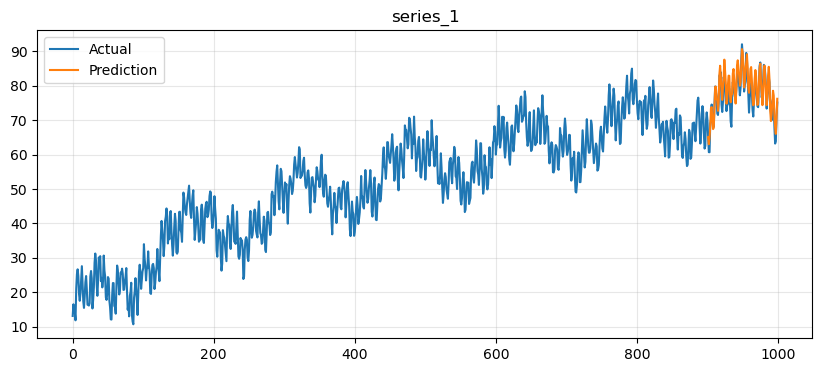

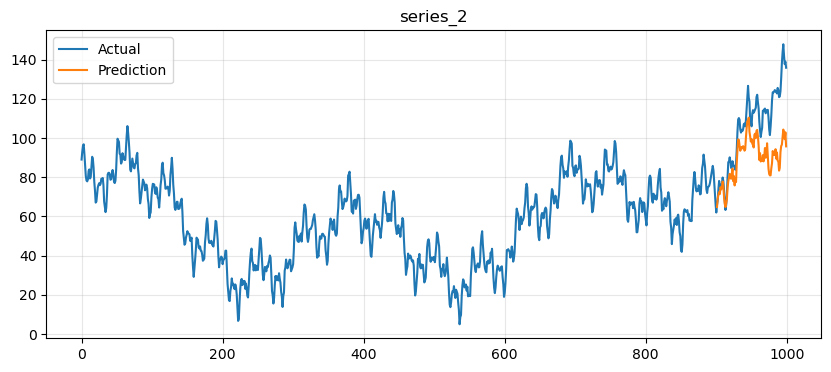

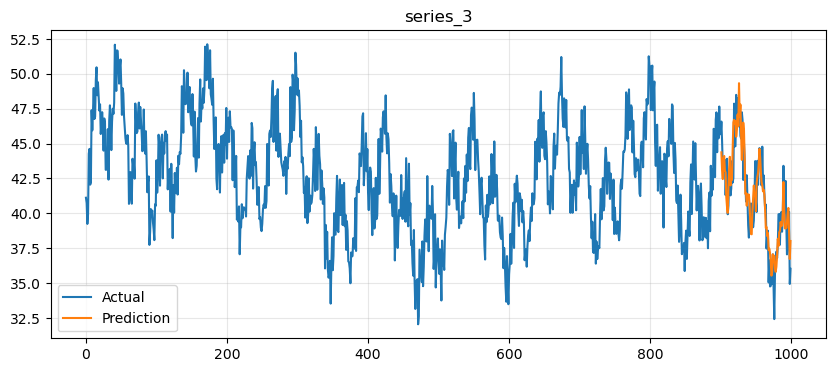

In [18]:
## Check the prediction accuracy
for key in data['series_key'].unique():
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(data[data['series_key']==key]['time_idx'],
             data[data['series_key']==key]['y'], label='Actual')
    plt.plot(prediction[prediction['series_key']==key]['time_idx'],
             prediction[prediction['series_key']==key]['pred'], label='Prediction')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(key)
    plt.show()